In [3]:
import numpy as np
import pandas as pd, re
import matplotlib.pyplot as plt
import tensorflow
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""
#to plot within notebook
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
scaler = MinMaxScaler(feature_range = (0, 1))
#from matplotlib.pylab import rcParams
#rcParams['figure.figsize'] = 20,10
df = pd.read_csv("../Datasets/gazprom4years.csv")
df = df.drop('<TIME>', 1)
df.columns = df.columns.str.replace('<|>', '')
df.head()

,DATE,OPEN,HIGH,LOW,CLOSE,VOL
0,05/02/14,141.29,142.75,140.72,141.97,46136210
1,06/02/14,142.30,143.50,141.18,143.48,39337120
2,07/02/14,144.26,146.87,144.10,146.42,47634360
3,10/02/14,146.87,147.90,146.41,146.89,34146400
4,11/02/14,147.03,149.25,146.51,147.60,47937570


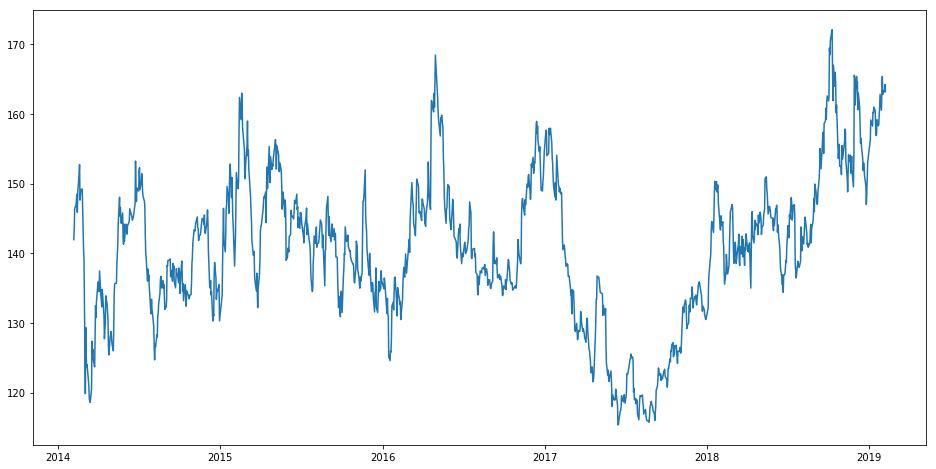

In [4]:
df['DATE'] = pd.to_datetime(df.DATE, format = '%d/%m/%y')
df.index = df['DATE']

plt.figure(figsize = (16, 8))
plt.plot(df['CLOSE'], label = 'Close price history')

In [5]:
#AVERAGE METHOD
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index = range(0, len(df)), columns = ['DATE', 'CLOSE'])
for i in range(0,len(data)):
     new_data['DATE'][i] = data['DATE'][i]
     new_data['CLOSE'][i] = data['CLOSE'][i]
new_data.head()

,DATE,CLOSE
0,2014-02-05 00:00:00,141.97
1,2014-02-06 00:00:00,143.48
2,2014-02-07 00:00:00,146.42
3,2014-02-10 00:00:00,146.89
4,2014-02-11 00:00:00,147.6


In [6]:
train = new_data[:900]
test = new_data[900:]# 361
test_len = test.shape[0]
preds = []
total_sum = 0
for i in range(0, test_len):
    a = train['CLOSE'][len(train)- test_len + i : len(train)+ i].sum() + total_sum
    aver = a / test_len
    total_sum += aver
    preds.append(aver)

In [7]:
rms=np.sqrt(np.mean(np.power((np.array(test['CLOSE'])-preds),2)))
rms

17.13392067564636

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


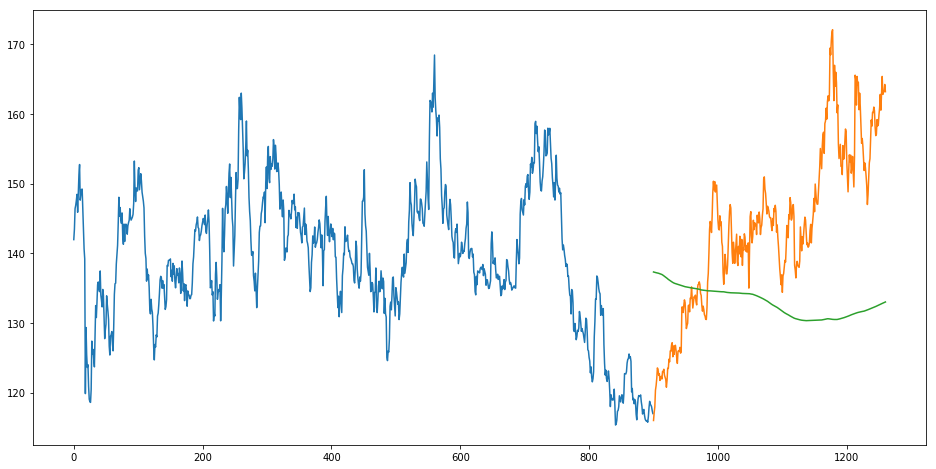

In [8]:
test['Predictions'] = preds
plt.figure(figsize = (16, 8))
plt.plot(train['CLOSE'])
plt.plot(test.loc[:,'CLOSE': 'Predictions'])

In [9]:
#LINEAR REGRESSION
def add_datepart(df, fldname, drop=True, time=False, errors="raise"):	
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ATE$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)
add_datepart(new_data, 'DATE')
new_data.head()

,CLOSE,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,141.97,2014,2,6,5,2,36,False,False,False,False,False,False,1391558400
1,143.48,2014,2,6,6,3,37,False,False,False,False,False,False,1391644800
2,146.42,2014,2,6,7,4,38,False,False,False,False,False,False,1391731200
3,146.89,2014,2,7,10,0,41,False,False,False,False,False,False,1391990400
4,147.6,2014,2,7,11,1,42,False,False,False,False,False,False,1392076800


In [10]:
#new_data.drop('Elapsed', axis=1, inplace=True)
arr = []
for i in range(0,len(new_data)):
    if (new_data['Dayofweek'][i] == 0 or new_data['Dayofweek'][i] == 4):
        arr.append(1)
    else:
        arr.append(0)
new_data['mon_fri'] = arr

In [11]:
new_data.head()

,CLOSE,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,mon_fri
0,141.97,2014,2,6,5,2,36,False,False,False,False,False,False,1391558400,0
1,143.48,2014,2,6,6,3,37,False,False,False,False,False,False,1391644800,0
2,146.42,2014,2,6,7,4,38,False,False,False,False,False,False,1391731200,1
3,146.89,2014,2,7,10,0,41,False,False,False,False,False,False,1391990400,1
4,147.6,2014,2,7,11,1,42,False,False,False,False,False,False,1392076800,0


In [38]:
#split data
train_len = round(new_data.shape[0] * 0.8)
test_start = train_len + 1
test_start
#train
train_data = new_data[:train_len]
x_train_data = train_data.drop('CLOSE', axis = 1)
y_train_data = train_data['CLOSE']
#test
test_data = new_data[test_start:]
x_test_data = test_data.drop('CLOSE', axis = 1)
y_test_data = test_data['CLOSE']

1008.8000000000001

In [13]:
#learn
model = LinearRegression()
model.fit(x_train_data, y_train_data)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [14]:
#check
predictions = model.predict(x_test_data)
rms_linear = np.sqrt(np.mean(np.power((np.array(y_test_data)-predictions), 2)))
rms_linear

20.286715997041334

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


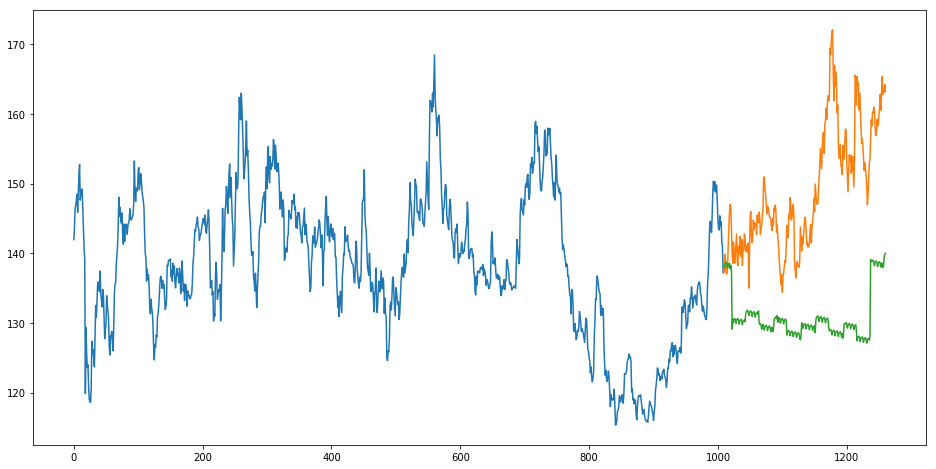

In [15]:
test_data['Predictions'] = predictions
plt.figure(figsize = (16, 8))
plt.plot(y_train_data)
plt.plot(test_data[['CLOSE', 'Predictions']])

In [16]:
#KNN
x_train_scaled = scaler.fit_transform(x_train_data)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_test_data)
x_valid = pd.DataFrame(x_valid_scaled)

params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

model.fit(x_train, y_train_data)
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_test_data) - np.array(preds)), 2)))
rms

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype bool, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


12.461027685734146

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


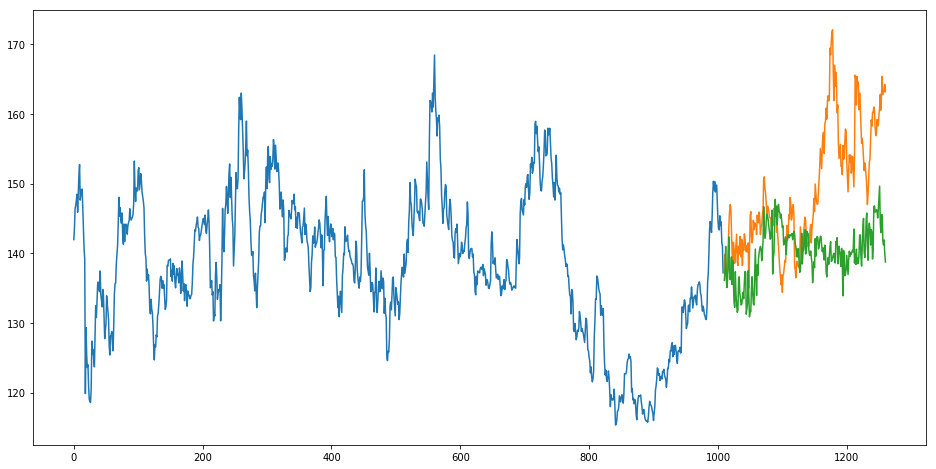

In [17]:
test_data['Predictions'] = preds
plt.figure(figsize = (16, 8))
plt.plot(y_train_data)
plt.plot(test_data[['CLOSE', 'Predictions']])

In [39]:
#LSTM
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['DATE', 'CLOSE'])
for i in range(0,len(data)):
    new_data['DATE'][i] = data['DATE'][i]
    new_data['CLOSE'][i] = data['CLOSE'][i]

#setting index
new_data.index = new_data.DATE
new_data.drop('DATE', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:1008,:]
valid = dataset[1008:,:]

In [41]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)) #меняет размерность массива на ту, что в скобках

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [42]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)#verbose - как мы видим прогресс обучения 

inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60 : i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Epoch 1/1
 - 80s - loss: 0.0065


In [43]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

2.9018750591582068

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


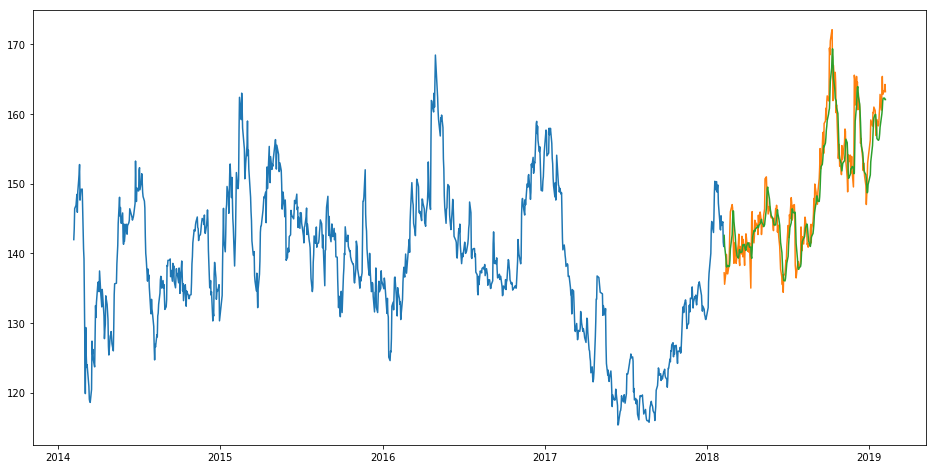

In [44]:
train = new_data[:1008]
valid = new_data[1008:]
valid['Predictions'] = closing_price
plt.figure(figsize = (16, 8))
plt.plot(train['CLOSE'])
plt.plot(valid[['CLOSE','Predictions']])